## Importing, time stepping, and grid spacing

In [36]:
import numpy as np
import climlab # package used for calculating orbital parameters overtime
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
import matplotlib.pyplot as plt
from scipy.sparse import diags


""" #timesteping 
t_i = 0
t_f = -5000 #run model for the past 700,000 years 
d_t = 1  #use time step of 100 years
t = np.arange(t_f, t_i+1, d_t)
t_kyr = (t/(1000)) # years in kyr, needed to calculate orbital parameters """

""" #grid spacing
x_i = 0 # corresponds to 74 degrees N latitute (northern boundary) 
x_f = 400000 # corresponds to 60 degrees N latitude (southern boundary)
d_x = 800
x = np.arange(x_i, x_f, d_x) """

#timesteping 
t_i = 0
t_f = -40000 #run model for the past 700,000 years 
d_t = 100 #use time step of 100 years
t = np.arange(t_f, t_i+1, d_t)
t_kyr = (t/(1000)) # years in kyr, needed to calculate orbital parameters

#grid spacing
x_i = 65 # degrees North latitude (southern boundary)
x_f = 74 # degrees North latitude (northern boundary)
d_x = 0.5 #0.5 degrees as spacial step equivalent to 55km
x = np.arange(x_i, x_f+.5, d_x)

(500,)

## Calculating orbital parameters

Slight changes in the Earth's orbit cause different level of insolation over long time periods. These changes happen at regular frequencies and directly influence glacial melt and snow accumulation

In [37]:
days = np.linspace(1,365.24, 365)/365 * 365.24
orb = OrbitalTable.interp(kyear=t_kyr ) #calculate orbital parameters for past 700,000 years, every 100 years

Q = daily_insolation(x, days, orb) #calculate daily insolation per every 500 years based on orbit parameters


In [38]:
print(x)

[65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5 71.  71.5
 72.  72.5 73.  73.5 74. ]


The net annual mass balance on the ice sheet suface, depending on snowfall and ice melt, is given by
$$ G = \begin{cases}
a(h+h' -E) - b(h+h'-E)^2 & h+h' - E \leq 1500 \text{ m} \\
0.56 & h+h' - E > 1500 \text{ m}
\end{cases} \text{     m yr}^{-1} $$
where $E$ is defined 
$$E = E_0(x) + k \Delta Q$$
$E_0(x)$: the present equlibrium line<br>
$k$: insolation sensitivity <br>
$\Delta Q$: is the difference in the summer half-year insolation at $55 \degree$ N from that of the present <br>

**To calculate $\Delta Q:$** <br>
The summer half-year insolation is represents the amount of insolation integrated over the caloric summer half of the year, defined such that any day of the summer half receives more insolation than any day of the winter half (Milankovitch, 1941; Berger, 1978). We need to calculate this at each latitute for ever time step, and subtract the summer half-year insolation at $55 \degree$ N. 



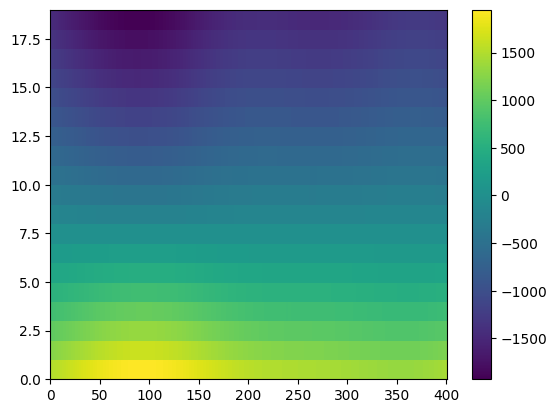

In [39]:
#to calculate summer half year insolation, we first need to find the upper half of the daily insolations
# we do this by splitting the data by the along median, then adding the remaining values 

delta_Q = np.zeros((len(x), len(t_kyr)))

for i in range(len(t_kyr)):
    daily_68 = Q[7, :, i]
    median_insolation_68 = np.median(daily_68)
    summer_total_68 = sum(daily_68[daily_68>median_insolation_68])
    for j in range(len(x)):
        daily = Q[j,:, i]
        median_insolation = np.median(daily)
        summer_total = sum(daily[daily> median_insolation])
        #now need to subtract the 63 degree N summer half year from each latitute to find delta Q
        delta_Q[j, i] = summer_total - summer_total_68


plt.figure()
plt.pcolor(delta_Q)
plt.colorbar()


In [50]:
k = 25 #insolation sensitivity, meter light-years^-1 day

x_dis_south_km = np.array([0, 56, 111, 167, 222, 278, 333, 389, 444, 500, 556, 611, 667, 722, 778, 833, 889, 945, 1000 ])
x_dis_south = x_dis_south_km * 1000

E0 = (x_dis_south * 9e-4) - 6.57e-2

def E(t):
    return E0 + k * delta_Q[:,t] 


a = 0.81e-3 #years^-1
b = 0.3e-6 #meters^-3 years^-1
def G(t, h):
    G_vec = np.zeros(len(h))
    E_vals = E(t)
    print(E_vals.shape)
    for i in range(len(h)-1):
        if (h[i] - E_vals[i] >= 1500):
            G_vec[i] = a*(h[i]-E_vals[i]) - b*(h[i]-E_vals[i])**2
        else:
            G_vec[i] = 0.56
    return G_vec

h_ini = np.linspace(10, 0, 19) 

print(G(400, h_ini))


(19,)
[   0.56          0.56          0.56          0.56          0.56
    0.56          0.56          0.56         -0.83507239   -9.46951901
  -24.95397921  -46.21768645  -72.31666383 -102.44957974 -135.88176671
 -171.99890964 -210.20777598 -250.01354119    0.        ]


-1481.0918805359288

### Boundary and Initial Conditions
For the initial height of the ice sheet we assume a rectangular cross section with a height of 920.43 meters. <br>
The boundary conditions for the southern boundary is that the height is zero (Dirichlet) <br>
For the northern boundary there is a no flux boundary condition


In [52]:
# Parameters
A = 5.77e-4 #meters^-3 years^-1
alpha = 5
beta = 2

# Initialize glacier 
#want to the northern part of glacier to be 920 m and decrease moving south so the southern border is 0 m
h_ini = np.linspace(920, 0, len(x))
h_ini[1] = h_ini[0]


def D(H_vec):
    Diff = np.zeros(len(H_vec))
    for i in range(len(Diff)-1):
        if (i == 0):
            Diff[0] = 1e-3 #abs(H_vec[1] - H_vec[0])**beta * H_vec[0]**alpha / (2*d_x)**beta
        elif(i == len(Diff - 1) ):
            Diff[i] = abs(0 - H_vec[i-1])**beta * H_vec[i]**alpha / (2*d_x)**beta
        else:
            Diff[i] = abs(H_vec[i+1] - H_vec[i-1])**beta * H_vec[i]**alpha / (2*d_x)**beta

    return Diff


def Alpha(D_vec):
    Alpha_diag = np.zeros((len(D_vec))-1)
    for i in range(1, len(D_vec)-1):
        Alpha_diag[i-1] = d_t/(4*d_x**2) * ( -D_vec[i+1] + D_vec[i-1] + 4 * D_vec[i]) * A * 0.7**(beta+1)
    Alpha_diag[-1] = 0
    return Alpha_diag

def Beta(D_vec):
    Beta_diag = np.zeros(len(D_vec))
    
    for i in range(0, len(D_vec)-1):
        Beta_diag[i] = d_t * ( (-2 * D_vec[i]) / d_x**2 + 1/d_t) * A * 0.7**(beta+1)
    Beta_diag[0] = 1
    Beta_diag[-1] = 1
    return Beta_diag

def Gamma(D_vec):
    Gamma_diag = np.zeros(len(D_vec)-1)
    
    for i in range(1, len(D_vec)-1):
        Gamma_diag[i] = (d_t)/(4*d_x**2) * ( D_vec[i+1] - D_vec[i-1] + 4 * D_vec[i]) * A * 0.7**(beta+1)

    Gamma_diag[0] = -1
    return Gamma_diag


sols = np.zeros((len(x), len(t)))
D_ini = D(h_ini)
diffs = np.zeros((len(D_ini), len(t)))
sols[:, 0] = h_ini
diffs[:, 0] = D_ini
h = h_ini

for i in range(0,5): #len(t)-1):
    
    #Solve for diffusivity value at each grid point
    Diffusivity = D(h)
    diffs[:, i] = Diffusivity
    print(Diffusivity)
    print("")

    #calculate entries in P matrix
    lower_diag = Alpha(Diffusivity)
    center_diag = Beta(Diffusivity)
    upper_diag = Gamma(Diffusivity)

    #Build P matrix to solve
    diagonals = [lower_diag, center_diag, upper_diag]
    M = diags(diagonals, [-1, 0, 1]).toarray()
    h[0] = 0
    h[-1] = 0
    M[0,0] = 1
    M[0, 1] = -1
    M[-1, -1] = 1
    M[-1, -2] = 0
    M_inv = np.linalg.inv(M)
    h_new = np.matmul(M_inv, h)
    
    h = h_new
    #update solutions
    sols[:, i+1] = h

    #print(h)




[920.         920.         872.82051282 849.23076923 825.64102564
 802.05128205 778.46153846 754.87179487 731.28205128 707.69230769
 684.1025641  660.51282051 636.92307692 613.33333333 589.74358974
 566.15384615 542.56410256 518.97435897 495.38461538 471.79487179
 448.20512821 424.61538462 401.02564103 377.43589744 353.84615385
 330.25641026 306.66666667 283.07692308 259.48717949 235.8974359
 212.30769231 188.71794872 165.12820513 141.53846154 117.94871795
  94.35897436  70.76923077  47.17948718  23.58974359   0.        ]
[1.00000000e-03 2.33385955e+07 4.03592252e+07 1.56409881e+07
 1.35860092e+07 1.17529332e+07 1.01232831e+07 8.67963722e+06
 7.40559830e+06 6.28576232e+06 5.30568755e+06 4.45186349e+06
 3.71167979e+06 3.07339529e+06 2.52610690e+06 2.05971860e+06
 1.66491038e+06 1.33310724e+06 1.05644807e+06 8.27754709e+05
 6.40500815e+05 4.88780878e+05 3.67279162e+05 2.71238663e+05
 1.96430073e+05 1.39120734e+05 9.60436029e+04 6.43662062e+04
 4.16596011e+04 2.58673347e+04 1.52744024e+04

In [29]:
print(max(diffs[:, 1]*d_t) / (d_x**2))


2.160095979563527e+22


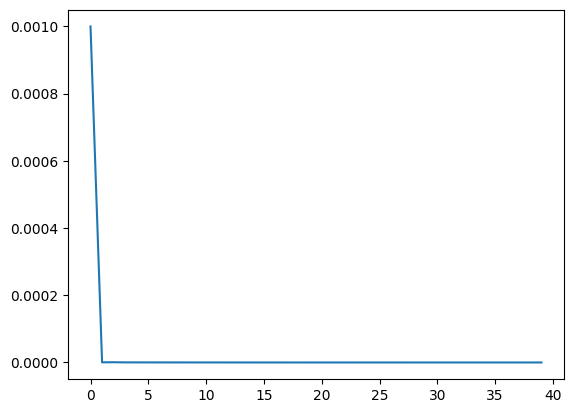

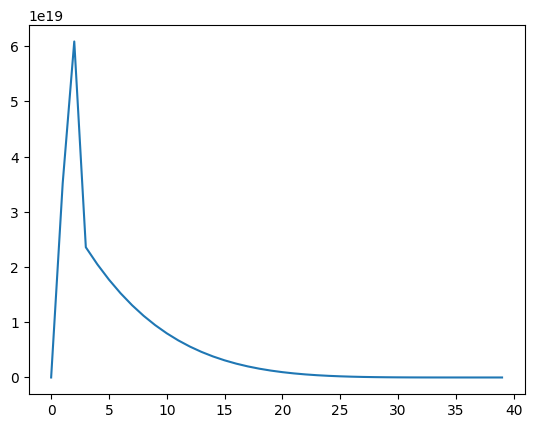

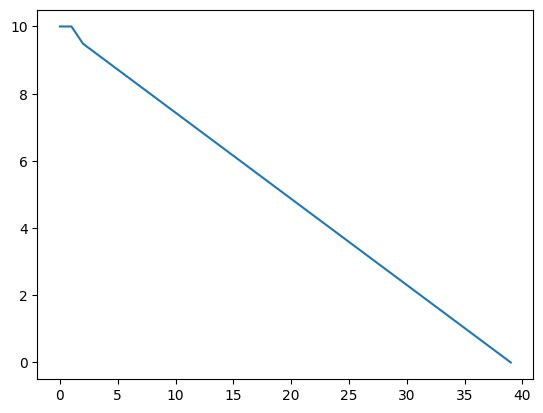

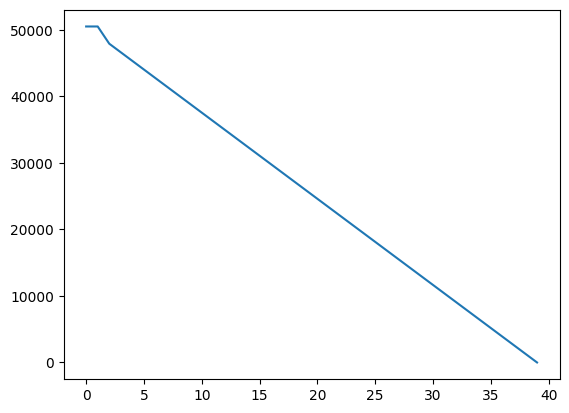

In [49]:
#print(max(D(h_ini)*d_t) / (d_x**2))
#print(D(h_ini))
plt.figure()
plt.plot(diffs[:, 0])
plt.figure()
plt.plot(diffs[:, 1])

plt.figure()
plt.plot(sols[:, 0])
plt.figure()
plt.plot(sols[:, 1])
